# Notebook 16: Expectation Maximization in practice


## Learning Goal 
The goal of this notebook is to gain intuition for Expectation Maximization using a simple example involving coin tosses.

## Overview

In Section XIV, we introduce Expectation-Maximization (EM) as a practical way to perform maximum likelihood estimation (MLE) even when some of the data is hidden (i.e in the presence of latent or hidden variables). To better understand EM, in this short notebook we'll explore a very simple coin-tossing example adapted from [Do and Batzoglou, Nat. Biotechnol. (2008)](https://www.nature.com/articles/nbt1406). 

Suppose that we are given two coins A and B with unkown bias $\theta_A$ and $\theta_B$, respectively. Our goal is to estimate the bias vector $\boldsymbol{\theta}= (\theta_A, \theta_B)$ from the outcomes of the following experiment: 

<blockquote> 
First choose one coin at random. Then toss the selected coin 10 times independently and record the number of heads observed. Repeat this procedure 5 times.
</blockquote>

Formally, let $z_i\in\{A,B\}$ be the coin selected in experiment $i$ and $x_i\in\{0,1,\cdots 10\}$ be the number heads recorded by tossing $z_i$ 10 times. Since we conduct $n=5$ such experiments, we can summarize the outcomes of these 50 tosses by two vectors: $\boldsymbol{x}=(x_1,x_2\cdots, x_5)$ and $\boldsymbol{z}=(z_1,z_2,\cdots, z_5)$.




### Exercise 1: What if we know everything?

 * Consider first the case where we have complete knowledge of the experiment, namely, both $\boldsymbol{x}$ and $\boldsymbol{z}$ are known. How would you intuitively estimate the biases of the two coins  $\boldsymbol{\theta}= (\theta_A, \theta_B)$ ?
 
 * What's the likelihood of observing the complete outcomes of these experiments? In other words, what is $P(\boldsymbol{x},\boldsymbol{z}| n,\boldsymbol{\theta} )$? You may assume this is a Bernoulli trial. Namely, every time coin A(B) is tossed, we have, with probability $\theta_A$($\theta_B$), that the outcome is heads.
 
 * What's the Maximum Likelihood Estimator (MLE)? Is this consistent with your intuition? 


### Answers to Exercise 1:

<ul>
    <li>If the outcomes and coins are known beforehand, one can find the probability that $n_H$ number of heads are observed for one of the coins out of $N$ trials: <br>
    $P\left(n_H | N \right) = \binom{N}{n_H} \theta^{n_H} (1-\theta)^{N-n_H}$ <br>
    This is the binomial distribution. For a single trial, one can find the probability (bias) $\theta$ such that the probability of observing $n_H$ heads in $N$ coin tosses is maximized. As an example, the binomial distribution as a function of coin bias (probability of heads) for the case with $N = 10$ and $n_H = 6$ is shown below:
    <img src="./binomial.png" height=400 width=400/>
    As can also be seen from the figure, the bias that maximizes the likelihood is (see below for proof) <br>
    $\theta = \frac{n_H}{N}$ for each coin, where $n_H$ is the total number of heads observed and $N$ is the total number of coin tosses.
    </li>
    <li>Assumming that we know the identity of the coin tossed and the coin tosses are independent from each other, the probability of observing the results of coin toss experiments is the product of the individual probabilities: <br>
    $P(x,z|n,\theta) = \prod_i Binomial(x_i|n,\theta_A)^{1-z_i} Binomial(x_i|n,\theta_B)^{z_i}$ where $z_i=0$ for coin A and $z_i=1$ for coin B. $x_i$ is the number of heads observed in the trial $i$.<br>
    </li>
    <li>MLE is merely the proportion of heads observed in coin tosses for each coin: <br>
    $MLE_{A} = \frac{n_A^H}{N_A}$ and $MLE_{B} = \frac{n_B^H}{N_B}$ such that $N_A + N_B = N$, the total number of coin tosses. This is consistent with the discussion above because bias given by MLE is the exact same bias that maximizes the binomial distribution. <br>
    <b>Proof:</b> Maximize $\log{P}$ with respect to the bias, $p$: <br>
    $\log{P} \sim \sum_i \left( n_H^i \log{p} + (N-n_H^i)\log{(1-p)} \right)$ <br>
    $\frac{\partial \log{P}}{\partial p} \sim \sum_i \left( \frac{n_H^i}{p} - \frac{N-n_H^i}{1-p} \right)$ <br>
    $\frac{\partial \log{P}}{\partial p} = 0 \implies \frac{1}{p(1-p)}\sum_i \left( n_H^i - pN \right) = 0$ <br>
    $\implies N_H - pN_{total} = 0$ <br>
    $\implies p = \frac{N_H}{N_{total}}$ <br>
    Therefore, the coin bias that maximizes the probability is the number of heads observed divided by the total number of trials for a given coin.
    </li>
</ul>

## Comparing MLE and EM

To test your answer, let's do some numerics! We will compare the MLE estimates of biases with an Expectation Maximization procedure where we do not know ${\bf z}$. The following code computes our best guess for the biases using MLE -- assuming we know the identity of the coin used -- and compares it estimates arrived at using an EM procedure where we have no knowledge about which coin was being tossed (though we know the same coin was tossed 10 times).

In [95]:
import numpy as np
from scipy.special import comb
import math


def compute_likelihood(obs, n, pheads): # No surprise, it's Binomial!!!

    likelihood = comb(n, obs, exact=True)*(pheads**obs)*(1.0-pheads)**(n-obs)

    return likelihood

def find_root(mu, sigma, N_tot, N_heads):
    '''Find the theta from the roots of the cubic equation to get the MAP estimate.'''
    roots = np.roots([1, -(mu+1), mu-N_tot*sigma**2, N_heads*sigma**2])
    theta = float(roots[(roots >=0) & (roots <1)])
    return round(theta, 4)
    

guess_theta_A_list = []
guess_theta_B_list = []
theta_A_list = []
theta_B_list = []
MLE_A_list = []
MLE_B_list = []

for trial in range(50000):
    print('{}/{}'.format(trial, 50000), end='\r')
    # generate experiments
    num_coin_toss = 10 # each experiment contains num_coin_toss tosses
    num_exp = 5  # we perform 5 such experiments
    theta_A_true = 0.8 
    theta_B_true = 0.4
    coin_choice = np.zeros(num_exp) # initialize: 0 for A and 1 for B
    head_counts = np.zeros(num_exp)

    # MLE 
    MLE_A = 0.0
    MLE_B = 0.0

    # generate the outcomes of experiment
    for i in np.arange(num_exp):

        if np.random.randint(2) == 0: # coin A is selected
            head_counts[i] = np.random.binomial(num_coin_toss , theta_A_true, 1) # toss coin A num_coin_toss times
            MLE_A = MLE_A +  head_counts[i] # add the number of heads observed to total headcounts 

        else: # coin B is selected 
            head_counts[i] = np.random.binomial(num_coin_toss , theta_B_true, 1) # toss coin B num_coin_toss times
            coin_choice[i] = 1  # record the selection of coin B during experiment i 
            MLE_B = MLE_B +  head_counts[i] # add the number of heads observed to total headcounts 

    tail_counts = num_coin_toss - head_counts

    try:
        # MLE is merely the proportion of heads for each coin toss
        MLE_A = MLE_A / ((num_exp - np.count_nonzero(coin_choice))*num_coin_toss)
        MLE_B = MLE_B / (np.count_nonzero(coin_choice)*num_coin_toss)
    except:
        continue

    MLE_A_list.append(MLE_A)
    MLE_B_list.append(MLE_B)
    
    # initialize the pA(heads) and pB(heads), namely, coin biases
    pA_heads = np.zeros(100); 
    pB_heads = np.zeros(100); 

    # Draw the guesses randomly from uniform distribution
    #pA_heads[0] = np.random.uniform()
    #pB_heads[0] = np.random.uniform()
    #print('*'*20)
    #print('Initial guesses: pA = {pA:.3f} pB = {pB:.3f}'.format(pA=pA_heads[0], pB=pB_heads[0]))

    pA_heads[0] = 0.60 # initial guess
    pB_heads[0] = 0.50 # initial guess

    # E-M begins!
    epsilon = 0.001   # error threshold
    j = 0 # iteration counter
    improvement = float('inf')

    while (improvement > epsilon):

        expectation_A = np.zeros((num_exp,2), dtype=float) 
        expectation_B = np.zeros((num_exp,2), dtype=float)

        for i in np.arange(min(len(head_counts),len(tail_counts))):

            eH = head_counts[i]
            eT = tail_counts[i]

            # E step:
            lA = compute_likelihood(eH, num_coin_toss, pA_heads[j])
            lB = compute_likelihood(eH, num_coin_toss, pB_heads[j])
            weightA = lA / (lA + lB) # Probability that coin A is chosen
            weightB = lB / (lA + lB) # Probability that coin B is chosen

            expectation_A[i] = weightA*np.array([eH, eT]) # Number of heads/tails assigned to A
            expectation_B[i] = weightB*np.array([eH, eT]) # Number of heads/tails assigned to B

        # M step
        theta_A = np.sum(expectation_A, axis = 0)[0] / np.sum(expectation_A) 
        theta_B = np.sum(expectation_B, axis = 0)[0] / np.sum(expectation_B) # MLE estimate 
        #N_tot_A = np.sum(expectation_A)
        #N_tot_B = np.sum(expectation_B)
        #N_heads_A = np.sum(expectation_A, axis = 0)[0]
        #N_heads_B = np.sum(expectation_B, axis = 0)[0]
        #try:
        #    theta_A = find_root(mu=0.83, sigma=1, N_heads=N_heads_A, N_tot=N_tot_A)
        #    theta_B = find_root(mu=0.37, sigma=1, N_heads=N_heads_B, N_tot=N_tot_B)
        #except: 
        #    print('Something happened')
        #    continue
        
        #print('At iteration %d, theta_A = %2f,  theta_B = %2f' % (j, theta_A, theta_B))

        pA_heads[j+1] = sum(expectation_A)[0] / sum(sum(expectation_A)); 
        pB_heads[j+1] = sum(expectation_B)[0] / sum(sum(expectation_B)); 
        #pA_heads[j+1] = theta_A
        #pB_heads[j+1] = theta_B

        improvement = max( abs(np.array([pA_heads[j+1],pB_heads[j+1]]) - np.array([pA_heads[j],pB_heads[j]]) ))
        j = j+1

    # END of E-M, print the outcome

    #print('E-M converges at iteration %d' %j)
    #print('RESULT:')
    #print('E-M: theta_A = %2f,  theta_B = %2f' % (theta_A, theta_B))
    #print('MLE with complete data: theta_A = %2f,  theta_B = %2f' % (MLE_A, MLE_B))
    
    guess_theta_A_list.append(pA_heads[0])
    guess_theta_B_list.append(pB_heads[0])
    theta_A_list.append(theta_A)
    theta_B_list.append(theta_B)

In [96]:
# Compare EM results with the true biases
theta_A_true = 0.8 
theta_B_true = 0.4

theta_A_list = np.array(theta_A_list)
theta_B_list = np.array(theta_B_list) 
guess_theta_A_list = np.array(guess_theta_A_list)
guess_theta_B_list = np.array(guess_theta_B_list)

def distance(guessA, guessB, trueA, trueB):
    return np.sqrt((guessA-trueA)**2 + (guessB-trueB)**2)

distances = distance(guess_theta_A_list, guess_theta_B_list, theta_A_true, theta_B_true)
min_distance_idx = np.argmin(distances)
max_distance_idx = np.argmax(distances)

print('Best guess for: ')
print('pA =', guess_theta_A_list[min_distance_idx])
print('pB =', guess_theta_B_list[min_distance_idx])

print('Worst guess for: ')
print('pA =', guess_theta_A_list[max_distance_idx])
print('pB =', guess_theta_B_list[max_distance_idx])


Best guess for: 
pA = 0.6
pB = 0.5
Worst guess for: 
pA = 0.6
pB = 0.5


AxesSubplot(0.125,0.536818;0.352273x0.343182) AxesSubplot(0.547727,0.536818;0.352273x0.343182)


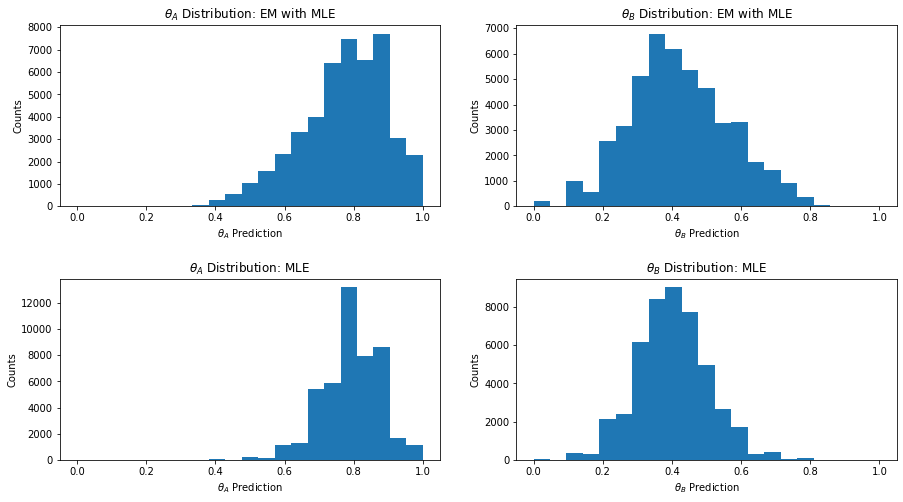

In [97]:
# Plot a histogram of results

from matplotlib import pyplot as plt

bins = np.linspace(0,1,22)
fig, axes = plt.subplots(nrows=2,ncols=2,figsize=(15,8))
ax1, ax2, ax3, ax4 = axes.flatten()
print(ax1, ax2)
ax1.set_xlabel(r'$\theta_A$ Prediction')
ax1.set_ylabel('Counts')
ax1.set_title(r'$\theta_A$ Distribution: EM with MLE')
ax1.hist(theta_A_list, bins=bins)

ax2.set_xlabel(r'$\theta_B$ Prediction')
ax2.set_ylabel('Counts')
ax2.set_title(r'$\theta_B$ Distribution: EM with MLE')
ax2.hist(theta_B_list, bins=bins)

ax3.set_xlabel(r'$\theta_A$ Prediction')
ax3.set_ylabel('Counts')
ax3.set_title(r'$\theta_A$ Distribution: MLE')
ax3.hist(MLE_A_list, bins=bins)

ax4.set_xlabel(r'$\theta_B$ Prediction')
ax4.set_ylabel('Counts')
ax4.set_title(r'$\theta_B$ Distribution: MLE')
ax4.hist(MLE_B_list, bins=bins)

plt.subplots_adjust(wspace=0.2, hspace=0.4)
fig.savefig('./em_mle_fixed_guess.png')
plt.show()

### Exercise 2

 * How fast does EM converge? Is the converged result close to what you'd get from MLE? 
 
 * Following Exercise 1, what's the objective function we're optimizing in the E-step? Does this function have a *unique global maximum*? 
 
 * Compare both the results of MLE and EM to the actual bias (i.e. *theta_A_true*  and *theta_B_true* in the snippet above), comment on their performance.
 


### Answers to Exercise 2:

<ul>
    <li>Convergence of EM algorithm depends on the random initialization. For some trials, it converges within 4-7 iterations, while the obtained biases are far from the biases obtained from MLE. For other trials, it converges within 15-20 iterations. The closeness of the bias results from MLE and EM heavily depend on the random generations of the coin toss experiment.</li>
    <li>In the E-step, we're looking at the likelihood (binomial) that the given number of heads are observed for either coin. We start with an initial guess of the bias for each coin, and at each step, we try to update the bias (probability of heads) of each coin such that the likelihood of observing the coin toss experiment outcome is maximized. This problem does not have a global maximum, so at each different run, results differ depending on the coin toss results, as the algorithm converges to a different local maximum.</li>
    <li>The result of EM algorithm heavily depends on the coin toss experiment generated. In cases where number of heads is significantly larger than the number of tails, it updates the bias in bigger steps and tends to overshoot, giving less accurate results than MLE. In the other situation, it tends to undershoot the actual bias. Therefore, overall MLE seems to have more accurate results. This can be motivated since in MLE, we have the knowledge of which coin is tossed, where in EM we don't have that knowledge, which makes the problem considerably harder. The histograms shown below support this conclusion: </li>
</ul>    
    <img src="./em_mle_fixed_guess.png" /> <br>
    
Comparing the histograms obtained with EM (top) with the histograms obtained with pure MLE approach (bottom), we see that both are peaked near the true bias for each coin. However, the width of the MLE distribution is smaller compared to the other one. Therefore, we can conclude that MLE approach gives better results more frequently, compared to EM. 



## Final remarks: a few practical tricks

From Exercise 2 and Section XIV, we know that the E-M algorithm often approximates the MLE even in the presence of latent (hidden variables). Like with most optimization methods for nonconcave functions, E-M only guarantees convergence to a local maximum of the objective function. For this reason, its performance can be boosted by running the EM procedure starting with multiple initial parameters. 

### Exercise 3

* Now instead of having a fixed initial guess of coin biases (i.e. *pA_heads[0]* and *pB_heads[0]* in the snippet), draw these values uniformly at random from $[0,1]$ and run the E-M algorithm. Repeat this twenty times and report what you observed. What's the best initial guess that gives the closest estimate to the true parameters?

* As we discussed in Section X (LinReg), **Maximum a posteriori (MAP)** estimation differs from MLE in that it employs an augmented objective function which incorporates a prior distribution over the quantities we want to estimate, and the prior distribution can be think of as a regularizer for the objective fuction used in MLE. Here we will explore how to extend E-M to MAP estimation. 

  (1) First derive the MAP estimate for the one-coin-flipping example, namely,
  $$
  \hat{{\theta}}_{MAP}(\boldsymbol{x}) = \arg\max_{\theta\in[0,1]} \log P(\boldsymbol{x}|n,{\theta} ) + \log P({\theta}),
  $$
  where 
  $$P(\boldsymbol{x}|n,{\theta}) = \prod_{i=1}^{10} \text{Binomial} (x_i|n,\theta)$$
  
  $$P({\theta})=\mathcal{N}(\theta|\mu, \sigma)$$
  
  (2) Based on (1), now modify the E-M snippet above to incorporate this prior distribution into the **M-step**. Comment on the performance. For the prior choice, try $P(\boldsymbol{\theta})=\mathcal{N}(\theta_A|0.83, 1)\mathcal{N}(\theta_B|0.37, 1)$.

### Answers to Exercise 3

* Randomly drawing first bias guesses from a uniform distribution between \[0, 1\], we get the most accurate results for the initial guesses that are the closest to the true biases. Similarly, we get the worst results for the initial guesses that are furthest away from the true biases. Out of 50000 trials, we get: <br>
  Best guess: <br>
  $p_A = 0.8013$ <br>
  $p_B = 0.3986$ 
  
  Worst guess: <br>
  $p_A = 0.0002$ <br>
  $p_B = 0.9896$
  
  Comparing these biases with the true biases, $p_A = 0.8$ and $p_B = 0.4$, we understand that we get the best estimates for the initial conditions that are closest to the actual values. Below, histograms are shown for the outcomes of the 50000 trials with EM and pure MLE estimators with both coins: <br>
  
  <img src="./em_mle.png"/> 
  
  For both coins, although we see some accumulation of trials near right bias ($0.8$ and $0.4$ for A and B, respectively), the distribution is pretty much flat around $\theta$ between $0.4$ and $0.9$. Our bias estimates with EM algorithm get close to the real biases for around $\sim 40 \%$ of the time. But from the MLE results (bottom), we can observe that the trials are peaked at the actual biases, therefore we can conclude that pure MLE estimation performs better in general. We also observe that the results for EM algorithm is <b>worse</b> compared to the case with the fixed initial guesses.

* (1) Calculating the quantity $\log{P(x|n,\theta)} + \log{P(\theta)}$ with the given likelihood and prior, we get: <br>
$\log{P} = \sum_{i=1}^5 \left( x_i\log{\theta} + (n-x_i)\log{(1-\theta)} \right) - \frac{(\theta - \mu)^2}{2\sigma^2} $, where we ignored the constant terms. Taking the derivative with respect to $\theta$, we get: <br>
$\frac{\partial \log{P}}{\partial \theta} = \sum_{i=1}^5 \left( \frac{x_i}{\theta} - \frac{n-x_i}{1-\theta} \right) - \frac{\theta - \mu}{\sigma^2}$ <br>
Maximizing $\log{P}$ by equating the derivative to zero, we get: <br>
$\frac{1}{\theta(1-\theta)}\sum_{i=1}^5 \left( x_i - n\theta \right) = \frac{\theta - \mu}{\sigma^2}$ <br>
Using $\sum_{i=1}^5 x_i = N_H$ and $\sum_{i=1}^5 n = N_{total}$, where $N_H$ is the total number of heads observed and $N_{total}$ is the total number of toin cosses, we get: <br>
$\frac{1}{\theta(1-\theta)}(N_H - N_{total}\theta) = \frac{\theta - \mu}{\sigma^2}$ <br>
Rearranging this equation, we get a cubic: <br>
$\theta^3 - (\mu + 1)\theta^2 + (\mu - N\sigma^2)\theta + \sigma^2 N_H = 0$ <br>
Given all the neccessary parameters, one can solve for $\theta$ that corresponds to the MAP estimate. In the code snippet above, this is done with `find_root()` function, which finds the three roots of the cubic equation, and finds $\theta$ by getting the root which is between 0 and 1.


* (2) Running the EM algorithm with the MAP estimate instead of MLE estimate, we still observe strong dependence on initial guesses for the two coin biases. If the initial guesses for the two biases are near the actual biases, then we get accurate results with EM, otherwise we get non-accurate results. With MAP estimate used in M step, we see the initial predictions with best and worst results are: <br>
  Best guess: <br>
  $p_A = 0.957$ <br>
  $p_B = 0.383$ 
  
  Worst guess: <br>
  $p_A = 0.053$ <br>
  $p_B = 0.931$
  
  Compared with $p_A^{true} = 0.8$ and $p_B^{true} = 0.4$, we see that the closer the initial conditions are to the actual biases, the better the results are.
  